# Kernel-Galerkin method with Quadratic Energy

## Imports & Intro

This notebook contains a demo of the kernel-galerkin method in the one-dimensional case, showcasing how the method works and is implemented in this library.

In [1]:
import sys
import os
project_root = os.path.abspath("..")  # If notebooks is one folder above src, change accordingly.
if project_root not in sys.path:
    sys.path.insert(0, project_root)

import numpy as np
import pandas as pd
import ipywidgets as widgets
import torch
from matplotlib import pyplot as plt
from matplotlib.cm import get_cmap
from tqdm import tqdm

from src.energy.quadratic import QuadraticEnergy

from src.eigensolver.galerkin.kernel_basis import KernelBasis
from src.eigensolver.galerkin.constant_basis import ConstantBasis
from src.eigensolver.galerkin.kernels.gaussian_kernel import GaussianKernel
from src.eigensolver.galerkin.kernels.polynomial_kernel import PolynomialKernel
from src.eigensolver.galerkin.galerkin_eigensolver import GalerkinSolver

from src.metrics.eigen_evaluator import EigenEvaluator
from src.metrics.pde_evaluator import ExactPDEEvaluator
from src.metrics.reconstruction_evaluator import ReconstructionEvaluator

from src.pdesolver.exact_solver import ExactEigenSolver
from src.pdesolver.fitted_solver import FittedEigenSolver


Consider the operator defined through
$$\mathcal{L}f = -\Delta f + <\nabla E, \nabla f>$$
where $E: \mathbb{R}^d \to \mathbb{R}$ is a given energy function and $<\cdot, \cdot>$ represents the Euclidian inner product. We say that a function $f: \mathbb{R}^d \to \mathbb{R}$  is an eigenfunction of $\mathcal{L}$ if it satisfies $\mathcal{L}f = \lambda f$ for some $\lambda \in \mathbb{R}$. It can be shown that under some conditions on $E$, the above operator has a discrete spectrum, and our goal here is to find the eigenfunctions and associated eigenvalues of $\mathcal{L}$ (note that the constant function is always an eigenfunction with corresponding eigenvalue 0). It can be shown that eigenfunctions with different eigenvalues are orthogonal w.r.t. the inner product defined through
$$<f, g>_\mu = \int f g\ d\mu$$
where $\mu$ is the probability density defined through $\mu(x) \propto \exp(-E(x))$.

In this notebook we will restrict ourselves to the quadratic energy case, where $E(x) = \frac{1}{2}\|x\|^2$. In this case, the eigenfunctions can be computed exactly: each eigenfunction is associated with a tuple $n=(n_1, \ldots, n_d) \in \mathbb{N}^d$, and is given by (up to normalization)
$$\phi_n(x) = H_1(x_1)\ldots H_n(x_n)$$
where $H_i$ denotes the $i$-th Hermite polynomial, which is a polynomial of degree $i$. The corresponding eigenvalue is $n_1 + \ldots + n_d$. Hence we have the following structure of the eigensystem of $\mathcal{L}$:
<center>

| Eigenvalue $\lambda$   | Multiplicity (dimension of eigenspace)| Function type
| :-------:      | :-------: | :------:
| 0       | 1    | Constant function
| 1       | $d$    | Linear functions
| 2       | $d(d+1)/2$ | Quadratic functions
| $\ldots$  | $\ldots$  | $\ldots$ 

</center>

In what follows, we illustrate how we can learn this eigensystem using the Kernel-galerkin method for various dimensions $d$.

## One-dimensional case

### Energy

We use the QuadraticEnergy object to evaluate the energy function and generate samples from $\mu$:

(-3.0, 3.0)

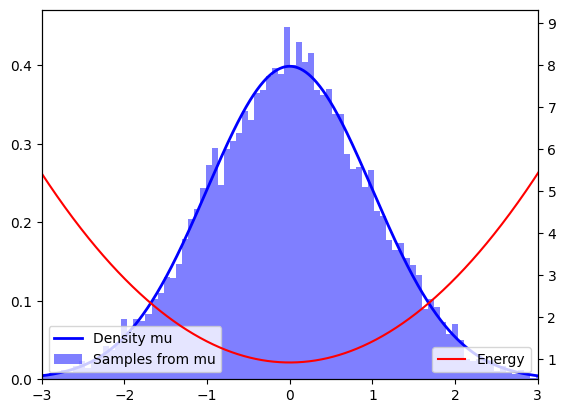

In [2]:
energy = QuadraticEnergy(torch.eye(1))
t = torch.linspace(-4,4,1000).unsqueeze(1)
plt.plot(t, torch.exp(-energy.forward(t)), label = "Density mu", color = 'blue', lw = 2)
plt.hist(energy.exact_sample((10000,)),bins=100,density=True, label = "Samples from mu",color="blue",alpha=.5)
plt.legend(loc = "lower left")
plt.twinx()
plt.plot(t, energy.forward(t), label = "Energy",color='red')
plt.legend(loc = "lower right")
plt.xlim(-3,3)

It also allows us to access the true eigensystem (since $d=1$ each eigenvalue has multiplicity 1):

(-3.0, 3.0)

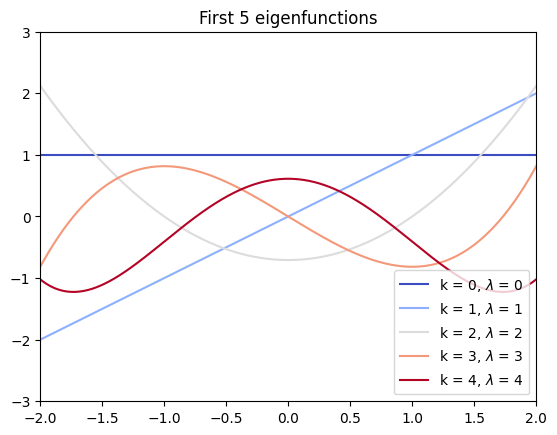

In [3]:
k = 5

exact_eigfuncs = energy.exact_eigfunctions(t,k)
exact_eigvals = energy.exact_eigvals(k)

colormap_name = 'coolwarm'
colormap = plt.get_cmap(colormap_name)

colors = [colormap(i / (k - 1)) for i in range(k)]

for i in range(k):
    plt.plot(t,exact_eigfuncs[:,i], label = f"k = {i}, $\\lambda$ = {exact_eigvals[i]:.0f}", color = colors[i])
plt.legend(loc="lower right")
plt.title(f"First {k} eigenfunctions")
plt.xlim(-2,2)
plt.ylim(-3,3)


### Kernel

The idea of the Galerkin method is to solve the eigenproblem in a finite-dimensional subspace of $L^2(\mu)$, which is defined through the choice of some basis elements $\{b_1,\ldots,b_p\}$. In the kernel method, we sample some points $x_1,\ldots,x_p \sim \mu$ and then set $b_i(x) = k(x,x_i)$ for some fixed kernel $k$. As an example, we can use the RBF kernel defined through
$$k(x,y) = \exp(\|x-y\|^2/(2\sigma^2))$$
for some scale parameter $\sigma$. In our experiments, we will also introduce a constant basis function $b_0(x) = 1$.

Text(0.5, 1.0, '10 kernel basis functions')

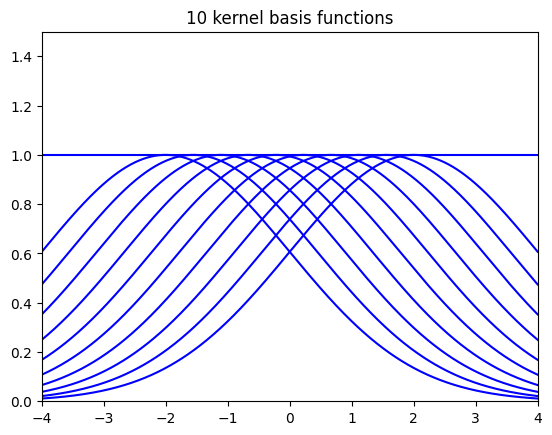

In [4]:
p = 10

kernel_params = {
    'dim': 1,
    'scale': 2,
}

kernel = GaussianKernel(kernel_params)

basis_points = torch.linspace(-2,2,p).unsqueeze(1)

kernel_basis = KernelBasis(kernel, basis_points)

# add constant function
basis = ConstantBasis(kernel_basis)

# In practice, we would use samples from mu

plt.plot(t, basis(t),color = 'blue', label = "Basis functions")

plt.xlim(-4,4)
plt.ylim(0,1.5)
plt.title(f'{p} kernel basis functions')

### Galerkin

The idea is now to reduce the infinite-dimensional problem to solving a finite-dimensional eigenvalue problem in the space spanned by the above basis functions. Introduce the operator
$$F: \mathbb{R}^p \to L^2(\mu): \alpha \mapsto \sum_{i=1}^p \alpha_i b_i$$
which maps a set of coordinates to the associated function under this basis. Then (TODO: more explanation) we consider the matrix
$$L = F^* \mathcal{L} F$$
as the "projection" of the operator $\mathcal{L}$ on the finite-dimensional subspace. Here $F^*$ is the adjoint of $F$ w.r.t. the inner product $<\cdot, \cdot>_\mu$. It can be shown that
$$L_{ij} = \mathbb{E}_{x\sim \mu} \left[<\nabla b_i(x), \nabla b_j(x)>\right]$$
Furtermore, we want to impose an orthonormality condition on our eigenfunctions. In $L^2(\mu)$, this is given by $<\phi_i, \phi_j>_\mu = \delta_{ij}$, so for functions with coordinates $\alpha_i, \alpha_j$ this becomes
$$<F\alpha_i, F\alpha_j>_\mu = <\alpha_i, F^*F\alpha_j> = \delta_{ij}$$
We denote $\Phi = F^*F$. This matrix can be computed as 
$$\Phi_{ij} = \mathbb{E}_{x\sim\mu}\left[b_i(x)b_j(x)\right]$$
Thus, we have the following "projection" of the problem on our finite-dimensional space:
$$\text{Find } A \in \mathbb{R}^{k\times p} \text{ such that } ALA^T = \Lambda, \qquad A\Phi A^T = I$$
This is a so-called generalized eigenvalue problem. Given such an $A$, our estimate of the $i$-th eigenfunction is then
$$\hat \phi_i(x) = \sum_{j=1}^p A_{ij} b_j(x).$$

The following code does this operation for our simple case. Note that it is important here to use double precision.

In [38]:
from scipy.linalg import eigh

torch.manual_seed(42)
samples = energy.exact_sample((10000,)).double()

grad_basis = basis.grad(samples)
L = torch.bmm(grad_basis, grad_basis.transpose(1,2)).mean(dim=0)

eval_basis = basis(samples)
Phi = torch.mean(eval_basis[:,:,None]*eval_basis[:,None,:],dim=0)

# Phi and L should both be semi-positive definite, but this can be violated due to numerical errors.

phi_error = torch.linalg.eigvalsh(Phi)[0]
if phi_error >= 0:
    print('Phi is spd.')
else:
    phi_reg = -2*phi_error
    print(f'Phi is not spd, adding regularizer {phi_reg}')
    Phi = Phi + phi_reg*torch.eye(Phi.size(0),dtype=torch.float64)

L = L + 1e-6 * torch.eye(L.size(0),dtype=torch.float64)

# use scipy.eigh to solve generalized eigenvalue problem.
L, Phi = L.numpy(), Phi.numpy()
eigvals, eigvecs = eigh(L, Phi, subset_by_index=[0, k-1])

eigvals, eigvecs = torch.tensor(eigvals, dtype = torch.float32), torch.tensor(eigvecs, dtype = torch.float32)

Phi is not spd, adding regularizer 2.3847639549517227e-16


We can now evaluate the learned eigenvalues and eigenvectors:

Text(0.5, 1.0, 'Method versus true eigenvalues')

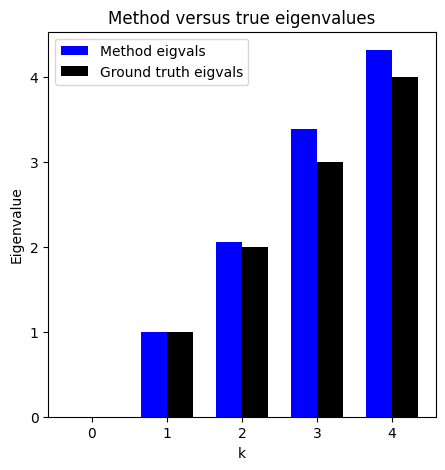

In [140]:
width = 0.35
plt.bar(torch.arange(k)-width/2,eigvals,width = width, label = "Method eigvals", color = "blue")
plt.bar(torch.arange(k)+width/2,exact_eigvals,width = width, label = "Ground truth eigvals", color='black')
plt.xlabel('k')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Method versus true eigenvalues')


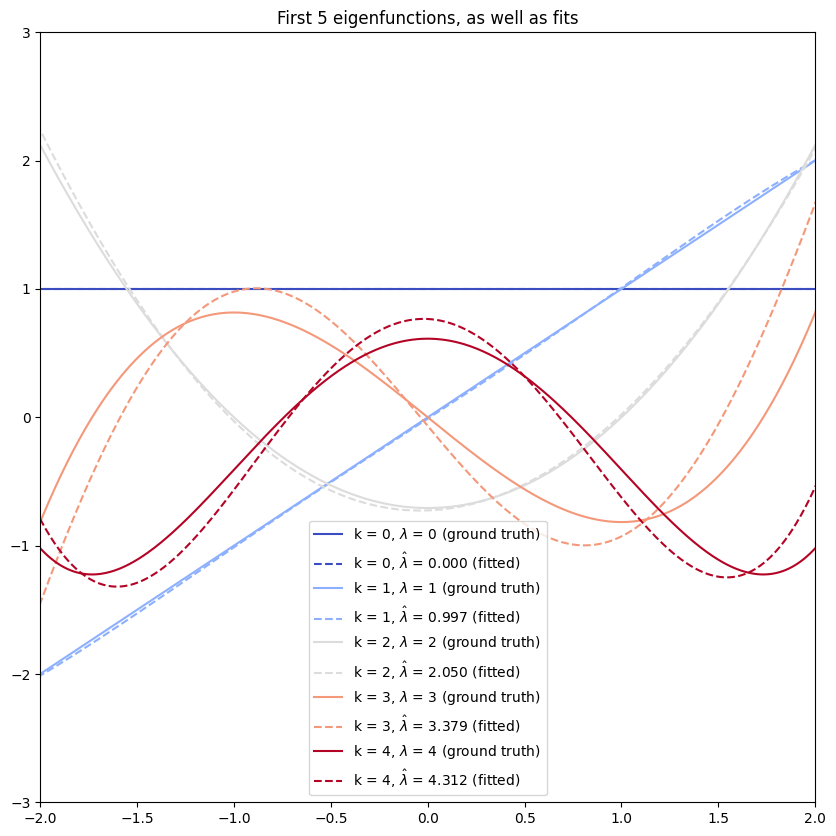

In [40]:
plt.rcParams['figure.figsize'] = [10, 10]

fitted_eigfuncs = basis(t) @ eigvecs

# eigenfunctions are only determined up to sign
err = ((fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)
neg_err = ((-fitted_eigfuncs - exact_eigfuncs)**2).mean(dim=0)

adjusted_fitted_eigfuncs = torch.where(err < neg_err, fitted_eigfuncs, -fitted_eigfuncs)

for i in range(k):
    plt.plot(t,exact_eigfuncs[:,i], label = f"k = {i}, $\\lambda$ = {exact_eigvals[i]:.0f} (ground truth)", color = colors[i])
    plt.plot(t,adjusted_fitted_eigfuncs[:,i], label = f"k = {i}, $\\hat\\lambda$ = {eigvals[i]:.3f} (fitted)", color = colors[i], ls = '--')

plt.legend(loc="lower right")
plt.title(f"First {k} eigenfunctions, as well as fits")
plt.xlim(-2,2)
plt.ylim(-3,3)
plt.legend()


All of the above is implemented in the <code>GalerkinSolver</code> class:

In [48]:
params = {
    'verbose': True,
    'num_samples': 10000
}

solver = GalerkinSolver(energy, samples, params)
solver = solver.fit(basis, k = k, L_reg = 1e-6, phi_reg= phi_reg, seed = 42)
print(f"Mean absolute difference between previous and module fitted eigfunctions: {torch.mean(torch.abs(solver.predict(t) - fitted_eigfuncs)):.3e}")
print(f"Mean absolute difference between previous and module fitted eigvalues: {torch.mean(torch.abs(solver.eigvals - eigvals)):.3e}")

Mean absolute difference between previous and module fitted eigfunctions: 1.895e-06
Mean absolute difference between previous and module fitted eigvalues: 9.643e-07


### Metrics

There are several different metrics we can consider, apart from comparing with the true eigensystem, which we consider here.

#### Eigen-error

The idea of this metric is that the defining property of an eigenfunction, $\mathcal{L}\phi = \lambda\phi$, is something that we can always check, even if we do not have access to the true eigensystem. Indeed, we can take some points $x \subset \mathbb{R}^d$ and see whether $\mathcal{L}\phi(x) \approx \lambda\phi(x)$. To make this more formal, we can fit the value $\hat\lambda$ which minimizes the squared error $\sum_{x} (\hat\lambda \phi(x) - \mathcal{L}\phi(x))^2$. The size of this squared error can then be considered as a metric for how much the function $\phi$ behaves like an eigenfunction, and $\lambda$ is an estimate of the eigenvalue based purely on evaluating $\phi$.

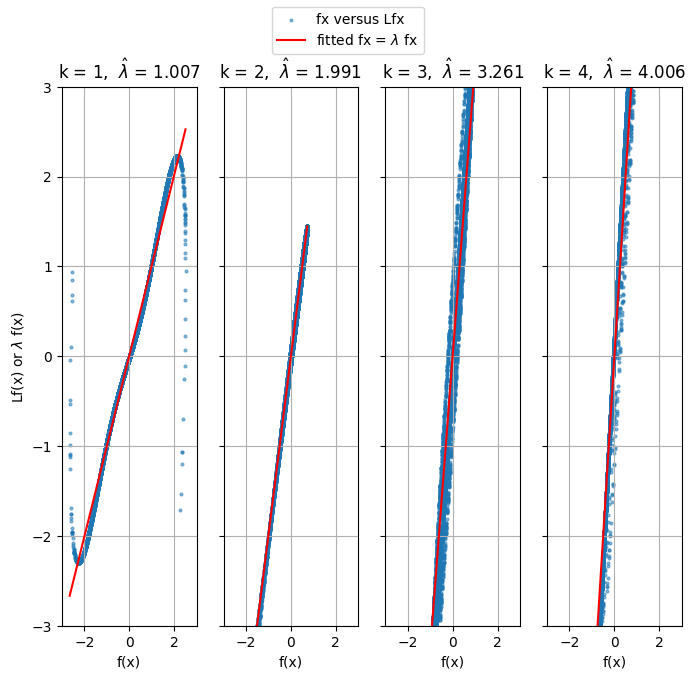

In [137]:
x = energy.exact_sample((10000,))
fitted_fx = solver.predict(x)
fitted_Lfx = solver.predict_Lf(x)

# closed form solution of OLS
fitted_eigvals = torch.sum(fitted_fx*fitted_Lfx,dim=0)/torch.sum(fitted_fx**2,dim=0)

fig, ax = plt.subplots(1,k-1,figsize=(8,7),sharey=True)

for i in range(1,k):
    ax[i-1].scatter(fitted_fx[:,i], fitted_Lfx[:,i],alpha=.5, label = "fx versus Lfx", s = 4)

    t = torch.linspace(fitted_fx[:,i].min(), fitted_fx[:,i].max(), 2).unsqueeze(1)
    ax[i-1].plot(t, fitted_eigvals[i]*t, color='red', label = f"fitted fx = $\\lambda$ fx")
    ax[i-1].set_xlabel('f(x)')
    ax[0].set_ylabel('Lf(x) or $\\lambda$ f(x)')
    ax[i-1].grid()
    ax[i-1].set_ylim(-3,3)
    ax[i-1].set_xlim(-3,3)
    ax[i-1].set_title(f'k = {i},  $\\hat\\lambda$ = {fitted_eigvals[i]:.3f}')
handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center')

This is implemented in the <code>GalerkinSolver</code> class as well:

In [138]:
torch.allclose(solver.fit_eigvals(x), fitted_eigvals)

True

The graph below shows how the fitted eigenvalues compare to the true eigenvalues and method eigenvalues:

Text(0.5, 1.0, 'Fitted versus true eigenvalues')

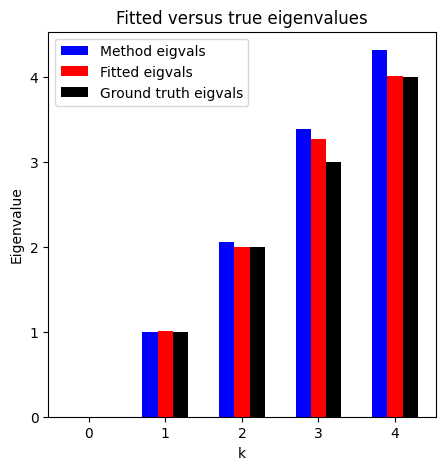

In [141]:
width = 0.2
plt.bar(torch.arange(k)-width,eigvals,width = width, label = "Method eigvals", color = "blue")
plt.bar(torch.arange(k),fitted_eigvals,width = width, label = "Fitted eigvals", color='red')
plt.bar(torch.arange(k)+width,exact_eigvals,width = width, label = "Ground truth eigvals", color='black')
plt.xlabel('k')
plt.ylabel('Eigenvalue')
plt.legend()
plt.title('Fitted versus true eigenvalues')


As you can see, it is possible that "fitting" the eigenvalues from the learned eigenfunction this way can lead to a more accurate estimate than the one produced by the method.